# Задача и ее описание

1	Описание: Дан набор данных, содержащий авторизационные данные нескольких пользователей в системы Windows. В нём отмечены события входа (авторизации пользователей на вход в систему) в рамках одной организации. Необходимо разработать метод детектирования аномалий, основанных на сформированном поведении наблюдаемого объекта.

1.1	Описание набора данных
	Поля:
	* rt		Время действия
	* duser		Учетная запись, в которую выполнен вход
	* group		Имя группы пользователя
	* dhost		Имя (id) системы, на которую пользователь выполнил вход
	* src		ipv4 адрес удаленного соединения, откуда пользователь инициировал процесс входа
	* LogonType	Тип входа: локальный (3) и удалённый (10). 
С 2020-03-02 начинается выборка для теста, данные до этого момента могут быть использованы для обучения, если метод предполагает обучение.

2	Задачи: 
	2.1 Сформулировать признаки, определяющие поведение и опеределить набор необходимых для поиска аномалий в авторизационных данных.
		В качестве объектов рассмотрения поведения можно рассмотреть:
		* Учётная запсь
		* Группа пользователей
		* Целевое устройство (система)
		* Организация в целом
	Аномальными для объектов могут быть время входа, адрес, с которого был выполнен вход, а также сочетания категорий внутри группы объектов.
	Примеры конкретных аномалий:
		* Адрес, с которого был выполнен вход (в первую очередь, интересна возможность выделения групп адресов по определённым признакам, например, подсетям)
		* Время входа (Рабочее время пользователя может быть оценено как относительно пользователя, так и относительно его группы)
		* Сочетание пары "пользователь - целевое устройство" 
	2.2 Разработать метод поиска определенных вами аномалий в приведённом наборе данных с помощью разработанного или адаптированного для этой задачи алгоритма.
	
В качестве решения ожидается список найденных аномалий и сам метод.

# Решение

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Считаем датасет, посмотрим на размер и проверим на пропущенные значения

In [2]:
data = pd.read_csv('rv_auth.csv', sep = ';')
print(f'Size of data: {data.shape[0]} X {data.shape[1]}')
print(f'Data have miss value: {data.isna().values.any()}')

Size of data: 8486 X 6
Data have miss value: False


Пропущенный значений нет, одной проблемой меньше. Теперь определим признаки.

In [3]:
print(data.head(), '\n')
print(data.dtypes, '\n')
print(data.nunique(), '\n')

                    rt     duser  group dhost         src  LogonType
0  2020-02-02 01:09:00   Lindsay  admin  SRV5  10.1.0.129         10
1  2020-02-02 02:00:00  Paulette  admin    DS     0.0.0.0          3
2  2020-02-02 04:14:00  Paulette  admin   PC1     0.0.0.0          3
3  2020-02-02 06:32:00  Paulette  admin   PC2     0.0.0.0          3
4  2020-02-02 08:52:00  Paulette  admin   PC3     0.0.0.0          3 

rt           object
duser        object
group        object
dhost        object
src          object
LogonType     int64
dtype: object 

rt           6687
duser          32
group           6
dhost          12
src            22
LogonType       2
dtype: int64 



По сути, все признаки - категориальные, кроме времени. На нем стоит заострить внимание. Посмотрим, за какой период времени собран датасет, а также сохраним значения в строковом типе для удобства дальнейшей обработки.

In [4]:
data['rt_str'] = data.rt
data.rt = data.rt.astype('datetime64')

date = sorted(data.rt)
print(np.timedelta64(date[-1] - date[0], 'D'))

43 days


Период небольшой, поэтому нам понадобится непосредственно само время, и, возможно, стоит посмотреть на дни недели. Для отображения остальных признаков, закодируем их методом LabelEncoder. Также разобьем датасет на тренировочный и тестовый.

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [6]:
time = np.array([60 * int(i[11:13]) + int(i[14:16]) for i in data.rt_str.values])
data['time'] = time
data['week_day'] = data.rt.dt.dayofweek


lb_make = LabelEncoder()
data[['duser_lb', 'group_lb', 'dhost_lb', 'src_lb']] = data[['duser', 'group', 'dhost', 'src']].apply(lb_make.fit_transform)

data_train = data[data.rt < '2020-03-02']
data_test = data[data.rt > '2020-03-02']

data.head()

,rt,duser,group,dhost,src,LogonType,rt_str,time,week_day,duser_lb,group_lb,dhost_lb,src_lb
0,2020-02-02 01:09:00,Lindsay,admin,SRV5,10.1.0.129,10,2020-02-02 01:09:00,69,6,17,0,11,16
1,2020-02-02 02:00:00,Paulette,admin,DS,0.0.0.0,3,2020-02-02 02:00:00,120,6,23,0,0,0
2,2020-02-02 04:14:00,Paulette,admin,PC1,0.0.0.0,3,2020-02-02 04:14:00,254,6,23,0,1,0
3,2020-02-02 06:32:00,Paulette,admin,PC2,0.0.0.0,3,2020-02-02 06:32:00,392,6,23,0,2,0
4,2020-02-02 08:52:00,Paulette,admin,PC3,0.0.0.0,3,2020-02-02 08:52:00,532,6,23,0,3,0


Теперь проверим не появилось ли новых значений среди наших признаков. Сначала сравним значения тренировочных и тестовых значений, а затем посмотрим, в каком наборе их больше. Если в тренировочном, то на результат не повлияет, если в тестовом - значит появились новые значения, которые можно принять за аномалии, в зависимости от признака.


In [7]:
for feature in ['duser', 'group', 'dhost', 'src', 'LogonType']:
    print(f'Equals of test and train unique values for {feature}:      \
        {sorted(data_train[feature].unique()) == sorted(data_test[feature].unique())}')


Equals of test and train unique values for duser:              True
Equals of test and train unique values for group:              True
Equals of test and train unique values for dhost:              True
Equals of test and train unique values for src:              False
Equals of test and train unique values for LogonType:              True


In [8]:
set(sorted(data_test.src.unique())) - set(sorted(data_train.src.unique()))

{'10.1.0.212', '10.1.123.1', '10.8.0.1'}

Видим, что в тестовом наборе появились новые адреса, скорее всего их можно принять за аномалии, будем смотреть дальше.

Теперь наши признаки готовы, чтобы посмотреть на их взаимное распределение. Строим pairplot.

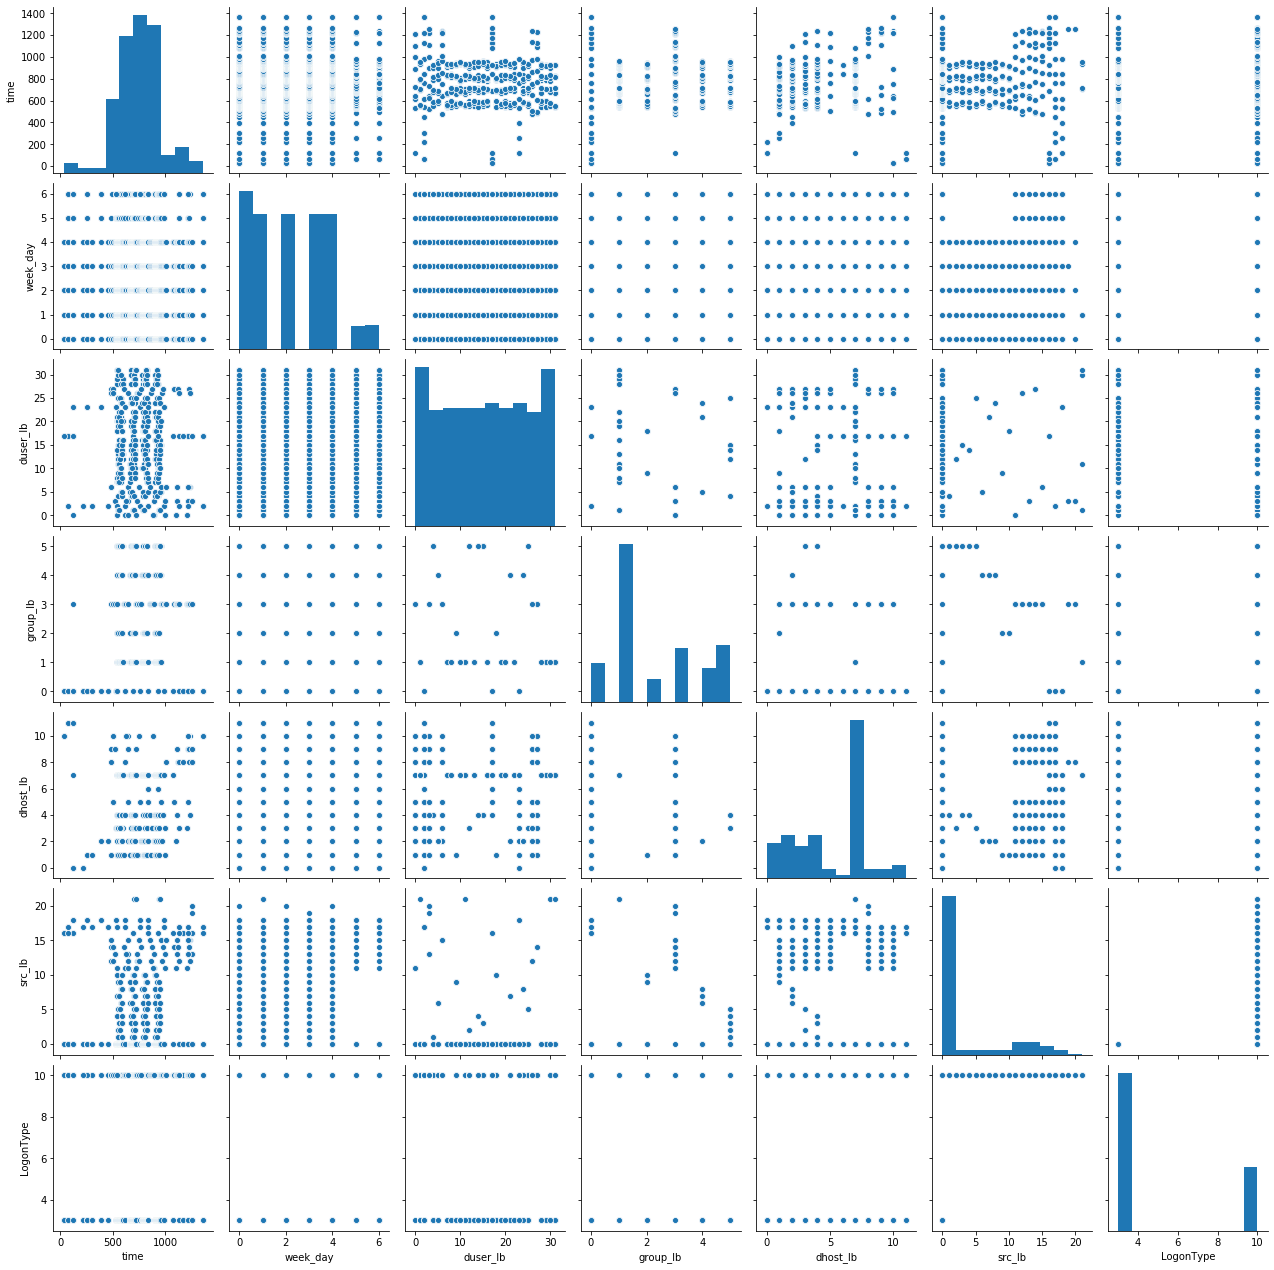

In [9]:
numeric_features = ['time', 'week_day', 'duser_lb', 'group_lb', 'dhost_lb', 'src_lb', 'LogonType']
sns.pairplot(data[numeric_features])

Начнем анализ:
1. Время.

    Здесь отчетливее всего видно, что по многим признакам (пользователь, группа, устройство, адрес) есть основное облако точек, а также точки от него отстоящие. Какие-то из них можно отнести к выбросам.
    

2. Дни недели.

    Как и предполагалось, этот признак недостаточно информативен
    
    
3. Пользователи.

    Точки достаточно разбросаны, также есть примеры далеко располжены друг от друга. Но, если в случае времени, это характеризовало неожиданное ночное время, при основной массе входов с утра до вечера, то здесь такие расстояния показывают лишь разных пользователей. Чтобы понять выброс это или нет, нужно смотреть конкретно по парам признаков. Не появилось ли у пользователя нового адреса в тестовом наборе или нового устройства.
    
Остальные признаки смотрим аналогично пользователям, по парам. В глаза бросается пара (Адрес, Тип входа). Видно, что для локального типа входа используется только один адрес. Посмотрим, в каком количстве с этого адреса заходили удаленно.

In [10]:
print(f'Adresses for local input:\n {data_train.src[data.LogonType == 3].value_counts()}\n')
print(f'Adresses for far input:\n {data_train.src[data.LogonType == 10].value_counts()}\n')
print(f'Adresses for local input:\n {data_test.src[data.LogonType == 3].value_counts()}\n')
print(f'Adresses for far input:\n {data_test.src[data.LogonType == 10].value_counts()}\n')

Adresses for local input:
 0.0.0.0    3939
Name: src, dtype: int64

Adresses for far input:
 10.1.0.113    161
10.1.0.114    161
10.1.0.110    161
10.1.0.112    161
10.1.0.111    161
10.1.0.129     67
10.1.0.131     64
10.1.0.130     62
10.1.0.107     56
10.1.0.102     56
10.1.0.105     56
10.1.0.100     56
10.1.0.109     56
10.1.0.108     56
10.1.0.104     56
10.1.0.101     56
10.1.0.103     56
10.1.0.106     56
Name: src, dtype: int64

Adresses for local input:
 0.0.0.0    2113
Name: src, dtype: int64

Adresses for far input:
 10.1.0.113    89
10.1.0.110    89
10.1.0.114    89
10.1.0.111    89
10.1.0.112    85
10.1.0.131    35
10.1.0.129    35
10.1.0.130    33
10.1.0.102    32
10.1.0.109    32
10.1.0.105    32
10.1.0.107    32
10.1.0.100    32
10.1.0.104    32
10.1.0.108    32
10.1.0.101    32
10.1.0.103    32
10.1.0.106    32
0.0.0.0        4
10.8.0.1       4
10.1.123.1     3
10.1.0.212     1
Name: src, dtype: int64



Ага, в тестовом наборе попались адреса, которыми он отличается от тренировочного, а также адрес '0.0.0.0', с которого заходят локально. Отнесем эти 12 значений к выбросам. Далее попытаемся построить модель, которая сможет их отловить.

Попробуем метод опорных векторов. Для того, чтобы она работала адекватно, закодируем признаки методом OneHotEncoder. Также пробежим по сетке параметров gamma и nu ядра классификатора. Будем оставлять только те, для которых классификатор дает 2% аномалий. Это гиперпараметр, который в дальнейшем можно настраивать.


# Метод опорных векторов

In [11]:
from sklearn.svm import OneClassSVM

In [12]:
%%time
encoder = OneHotEncoder()
onehot = encoder.fit_transform(data[['src', 'LogonType']])

train = onehot[:data_train.shape[0]]
test = onehot[data_train.shape[0]:]

best_score = []
for gamma in range(5, 15, 1):
    for nu in np.linspace(1e-2, 1e-1, 2e2):
        svm = OneClassSVM(gamma = gamma, nu = nu)
        svm.fit(train)

        labels = svm.predict(test)
        percent_anomaly = (labels == -1).mean()
        if percent_anomaly <= 0.02 and percent_anomaly > 0:
            print(f'Percent of anomaly: {round(percent_anomaly * 100, 4)}% for gamma = {gamma} and nu = {nu}')
            best_score.append([percent_anomaly, gamma, nu])


Percent of anomaly: 1.4721% for gamma = 5 and nu = 0.010452261306532663
Percent of anomaly: 1.4721% for gamma = 5 and nu = 0.029447236180904522
Percent of anomaly: 1.4721% for gamma = 5 and nu = 0.04844221105527639
Percent of anomaly: 1.4721% for gamma = 5 and nu = 0.058844221105527644
Percent of anomaly: 1.4721% for gamma = 5 and nu = 0.09683417085427136
Percent of anomaly: 1.4721% for gamma = 6 and nu = 0.010452261306532663
Percent of anomaly: 1.4721% for gamma = 6 and nu = 0.04844221105527639
Percent of anomaly: 1.4721% for gamma = 6 and nu = 0.058844221105527644
Percent of anomaly: 1.4721% for gamma = 6 and nu = 0.06246231155778895
Percent of anomaly: 1.4721% for gamma = 6 and nu = 0.06381909547738694
Percent of anomaly: 1.4721% for gamma = 6 and nu = 0.0778391959798995
Percent of anomaly: 1.4721% for gamma = 6 and nu = 0.09683417085427136
Percent of anomaly: 1.5055% for gamma = 7 and nu = 0.010452261306532663
Percent of anomaly: 1.4721% for gamma = 7 and nu = 0.029447236180904522


In [13]:
best = min(best_score)
print(best)
gamma, nu = best[1:]

svm = OneClassSVM(gamma = gamma, nu = nu)
svm.fit(train)

labels = svm.predict(test)

print(f'Percent of anomaly:{round((labels == -1).mean() * 100, 4)}% for gamma = {gamma} and nu = {nu}')
data_test.src[labels == -1].value_counts()


[0.014720642355302778, 5, 0.010452261306532663]
Percent of anomaly:1.4721% for gamma = 5 and nu = 0.010452261306532663


10.1.0.102    32
10.8.0.1       4
0.0.0.0        4
10.1.123.1     3
10.1.0.212     1
Name: src, dtype: int64

Классификатор отловил наши выбросы, но между тем, поймал еще и ненужный адрес, так как мы знаем, что помимо адреса '10.1.0.102' есть еще адреса в тестовом наборе, с которых заходили 32 раза. Попытаемся убрать эту оплошность в дальнейшем анализе.

# Визуализация данных

Перейдем к признаку 'Время'. Попробуем визуализировать с помощью метода t-SNE его распределение по пользователям. Предварительно отмасштабируем и закодируем пользователей с помощью OneHotEncoding()

In [14]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

In [15]:
model = TSNE()
encoder = OneHotEncoder()
scaler = StandardScaler()

onehot = encoder.fit_transform(data['duser'].values[:, np.newaxis]).toarray()

scale_time = scaler.fit_transform(data.time.values[:, np.newaxis])
onehot = np.concatenate((scale_time, onehot), axis = 1)

MDS_transformed = model.fit_transform(onehot)

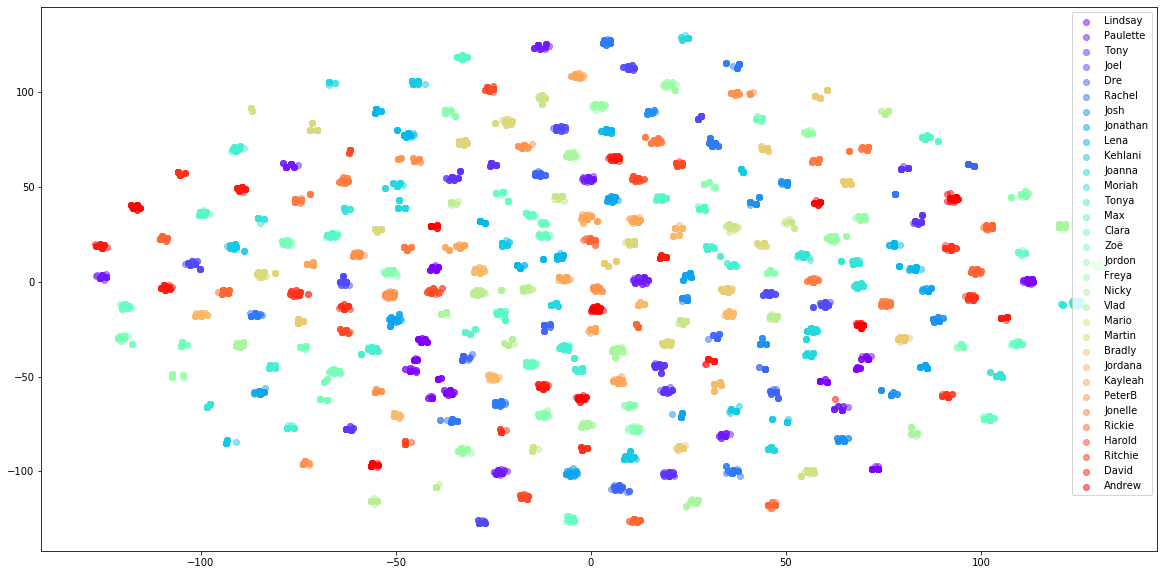

In [16]:
fig = plt.figure(figsize = (20, 10))
colors = np.array(cm.rainbow(np.linspace(0, 1, len(data.duser.unique()))))[:, np.newaxis]
for y, c in zip(data.duser.unique(), colors):
    plt.scatter(MDS_transformed[data.duser == y, 0], 
                MDS_transformed[data.duser == y, 1], 
                c = c, alpha = 0.5, label = str(y))
plt.legend()
plt.show()

Ничего хорошего не вышло, будем смотреть на распределение по каждому отдельному пользователю.

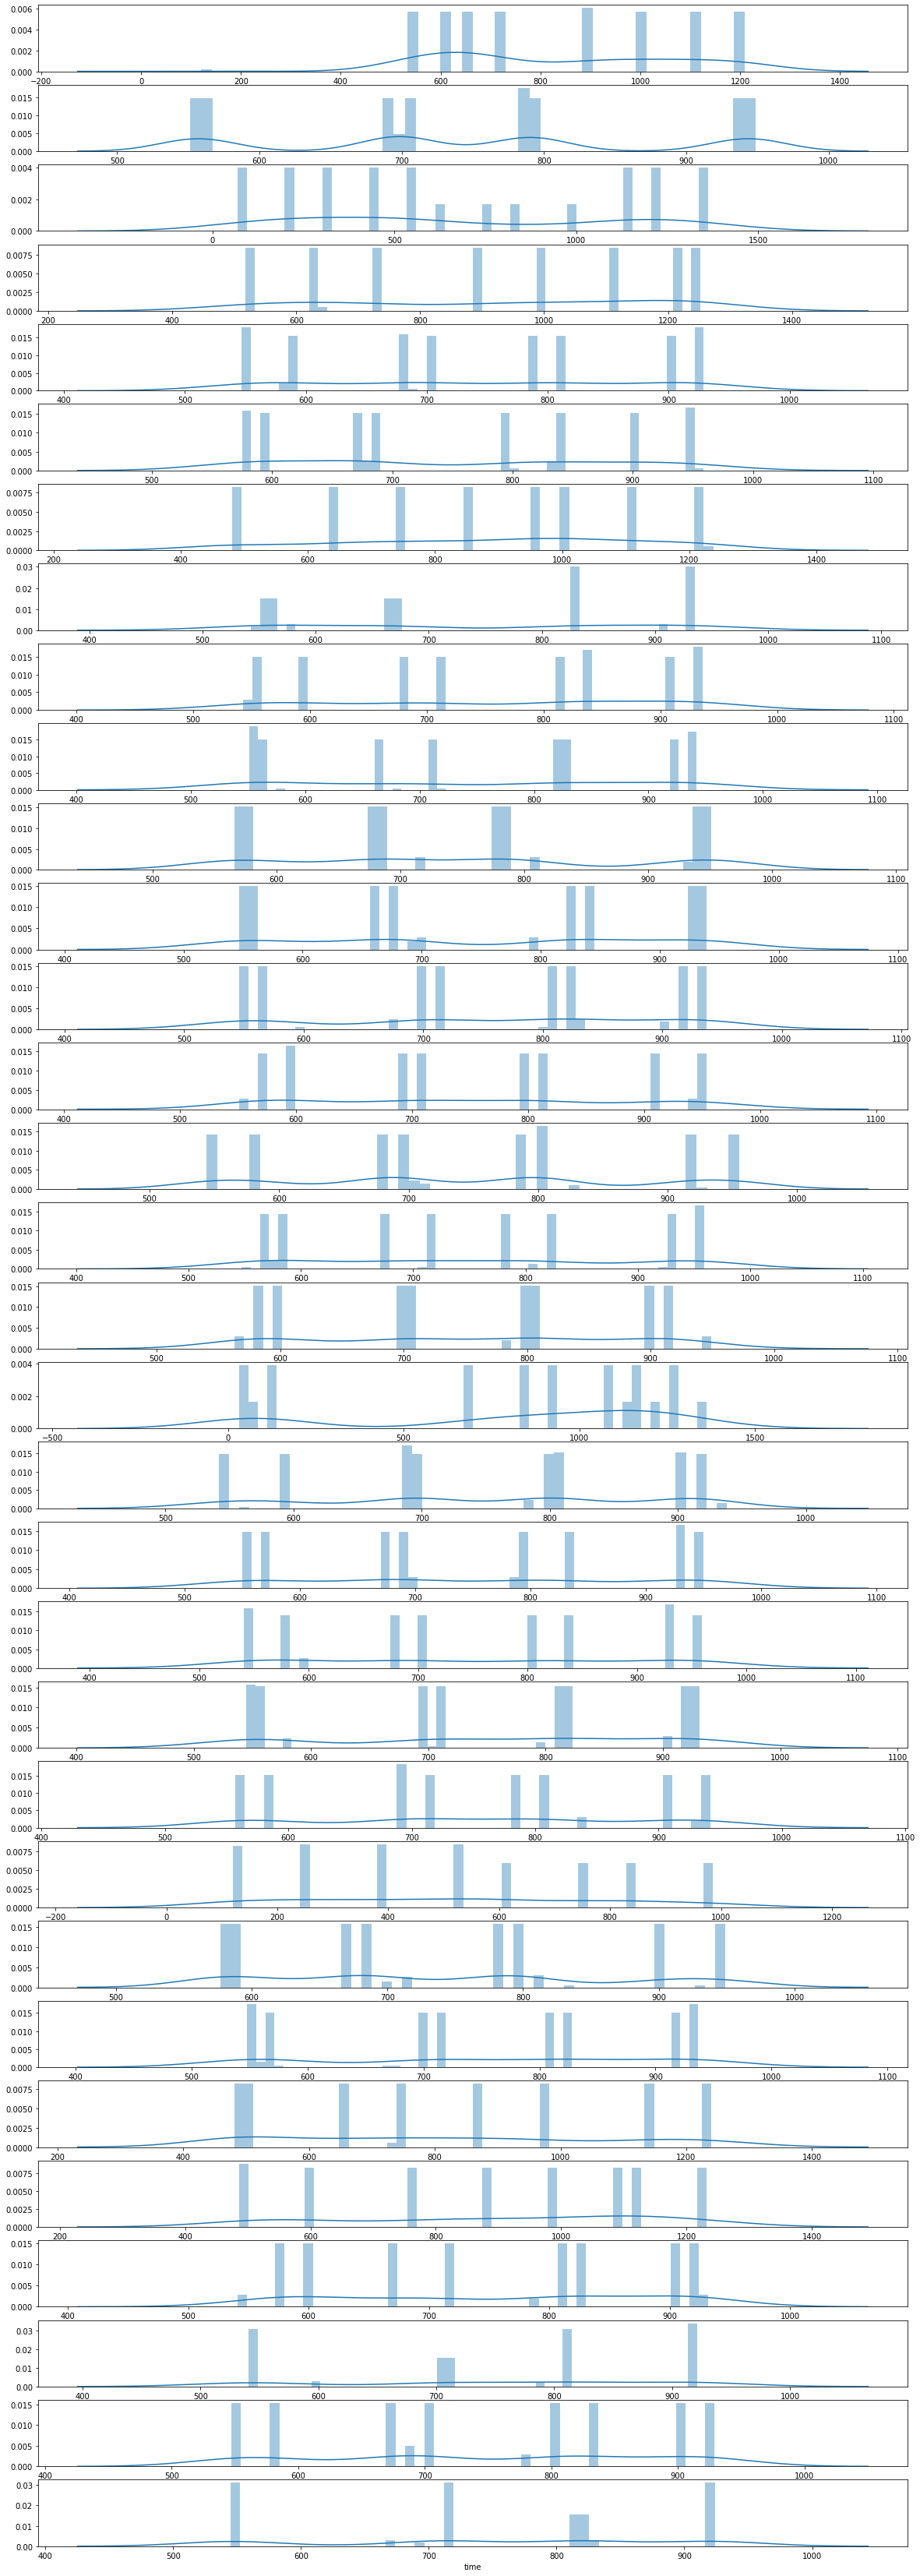

In [17]:
f, ax = plt.subplots(data.duser.unique().shape[0], 1, figsize = (20, 60))
for i in range(data.duser.unique().shape[0]):
    sns.distplot(data.time[data.duser_lb == i], bins = 50, ax = ax[i])

Намного лучше. Уже на первом графике видно, что с левого края распределения есть выброс. Значит будем пробежим по уникальным именам каждого признака и найдем значения времени, которые не входят в 99% интервал времен входа. Так как уникальные имена каждого признака, кроме "Адреса" совпадают, это будет достаточно просто. Для "Адреса" обусловимся тем, что незнакомый значение, будет отправлено в аномалии. В конце удалим дубликаты и отсортируем полученный датасет.

In [18]:
#Заведем датафрейм под аномалии
anomaly = pd.DataFrame()
#Выделим признаки, по кторым хотим посмотреть распределении по времени
cat_features = ['duser', 'group', 'dhost', 'src']

for feature in cat_features:
    #Заведем счетчик для пойманных аномалий для конкретного признака
    count = 0
    for value in data_test[feature].unique():
        #Условие для новых значений
        if value not in data_train[feature].unique():
            anomaly = pd.concat([anomaly, data_test[data_test[feature] == value]])
            count += data_test[data_test[feature] == value].shape[0]
            continue
        else:
            #Строим интервал, содержащий 99% значений
            interval = np.percentile(data_train.time[data_train[feature] == value], [0.5, 99.5])
            #Проверяем каждое значение времени входа на характерное для данного признака
            for time in data_test.time[data_test[feature] == value].unique():
                if time < interval[0] or time > interval[1]:
                    anomaly = pd.concat([anomaly, data_test[(data_test.time == time) & (data_test[feature] == value)]])
                    count += data_test[(data_test.time == time) & (data_test[feature] == value)].shape[0]
    print(f'For feature {feature} find {count} anomaly')

#Удалим дубликаты и отсортируем    
anomaly = anomaly.drop_duplicates().sort_index()

For feature duser find 5 anomaly
For feature group find 3 anomaly
For feature dhost find 2 anomaly
For feature src find 28 anomaly


Отлично, теперь займемся парами категориальных признаков. Напишем функцию, которая будет отлавливать новые устройства или новые адреса, которые не использовались данным пользователем, в общем, функция будет сравнивать выбранный признак используемый в паре с какм-то другим на тестовом и тренировочном наборах. И если в тестовом наборе появилось новая пара, то это будет сигналом отнести данный объект к аномалии.

In [19]:
#c_f - compare_feature - признак, для которого будет проводится сравнение на тренировочном и тестовом наборах
#cat_features - categorial features - набор признаков, каждый из которых будет ставится в пару к c_f
def pair(c_f, cat_features, anomaly):
    
    for feature in cat_features:
        #Заведем счетчик для пойманных аномалий
        count = 0
        #Списки уникальных имен для признака, который ставится в пару
        train_set = sorted(list(data_train[feature].unique()))
        test_set = sorted(list(data_test[feature].unique()))
        #Проверка на новые значения в тестовом наборе
        diff = list(set(test_set) - set(test_set))
        if diff:
            for value in diff:
                anomaly = pd.concat([anomaly, data_test[data_test[feature] == value]]) 
                count += data_test[data_test[feature] == value].shape[0]

        #Разбиваем имена признака c_f на группы по признаку, который ставится в пару        
        train_feature = [sorted(list(data_train[c_f][data_train[feature] == value].unique())) for value in train_set]
        test_feature = [sorted(list(data_test[c_f][data_test[feature] == value].unique())) for value in train_set]

        #Проверяем на новые значения в группах
        for i in range(len(train_set)):
            diff = list(set(test_feature[i]) - set(train_feature[i]))
            if diff:
                for v in diff:
                    anomaly = pd.concat([anomaly, data_test[(data_test[c_f] == v) & (data_test[feature] == train_set[i])]])
                    count += data_test[(data_test[c_f] == v) & (data_test[feature] == train_set[i])].shape[0]

        print(f'For feature {feature} find {count} anomaly')
    
    #Удаляем дубликаты и сортируем
    anomaly = anomaly.drop_duplicates().sort_index()
    return anomaly

Теперь применим эту функцию к интересующим нас парам:
    1. Пользователь в паре с группой, устройством, адресов входа.
    2. Группа в паре с устройстовом и адресом.
    3. Устройство в паре с адресом и типом входа
    4. Адрес в паре с типом входа

In [22]:
anomaly = pair('duser', ['group', 'dhost', 'src'], anomaly)
anomaly = pair('group', ['dhost', 'src'], anomaly)
anomaly = pair('dhost', ['src', 'LogonType'], anomaly)
anomaly = pair('src', ['LogonType'], anomaly)
anomaly = anomaly[['rt_str', 'duser', 'group', 'dhost', 'src', 'LogonType']]
anomaly

For feature group find 0 anomaly
For feature dhost find 1 anomaly
For feature src find 1 anomaly
For feature dhost find 1 anomaly
For feature src find 1 anomaly
For feature src find 0 anomaly
For feature LogonType find 0 anomaly
For feature LogonType find 12 anomaly


,rt_str,duser,group,dhost,src,LogonType
5753,2020-03-03 00:32:00,Lindsay,admin,SRV4,0.0.0.0,3
6008,2020-03-03 22:42:00,Clara,admin,SRV4,0.0.0.0,3
6009,2020-03-04 00:32:00,Lindsay,admin,SRV4,0.0.0.0,3
6264,2020-03-04 22:42:00,Clara,admin,SRV4,0.0.0.0,3
6371,2020-03-05 11:45:00,Vlad,buh,SRV1,0.0.0.0,10
6384,2020-03-05 11:57:00,Zoë,buh,SRV1,0.0.0.0,10
6484,2020-03-05 15:39:00,Jordana,buh,SRV1,0.0.0.0,10
6489,2020-03-05 15:49:00,Bradly,buh,SRV1,0.0.0.0,10
6521,2020-03-06 00:32:00,Lindsay,admin,SRV4,0.0.0.0,3
6774,2020-03-06 20:52:00,David,dev,SRV2,10.1.123.1,10


Запишем ответ в файл.

In [23]:
anomaly.to_csv('answer.csv')

P.S. У получившейся модели, есть нексолько гиперпараметров, которые можно регулировать: 
1. Интервал значений времени (здесь выбран 99%)
2. Количество новый значений пар признаков в тестовом наборе (здесь выбран +inf)